# Análise exploratória dos dados de queimadas
<hr style="border:2px solid #0077b9;">

- Obtendo os dados através da [SimpleGeo.py](https://github.com/vconrado/bdq.py)
- Explorando os dados ([seaborn](https://seaborn.pydata.org/))

# Objetivo
<hr style="border:2px solid #0077b9;">
Conhecer os dados, avaliando as correlações entre variáveis e suas distribuições

- Qual a relação entre o índice de risco a ocorrência de focos?
- Essa relação é constante em todas as regiões do país?
- E é constante nas estações do ano?

# Obtendo dados através da SimpleGeo
<hr style="border:2px solid #0077b9;">

In [12]:
from SimpleGeo import SimpleGeo, Predicates as pre

import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import display, HTML 
display(HTML("<style>.dataframe{font-size: 16px !important;}</style>"))

# Objeto SimpleGeo
s = SimpleGeo(wfs="http://www.terrama2.dpi.inpe.br/geoserver", wtss="http://www.terrama2.dpi.inpe.br/e-sensing", cache=True, cache_dir="/tmp/.simplegeo")

# Coverage e TimeSerie
c = s.coverage("rpth") \
    .attributes(["precipitation", "risk", "temperature", "humidity"])
ts = s.time_serie(c)  

In [15]:
# Feature Base
f = s.feature('esensing:focos_bra_2016') \
     .attributes(["timestamp","regiao","bioma","satelite","satelite_referencia",
                {'time_serie': ts, 'start_date': 0, 'end_date': 0, 'datetime': 'timestamp'}]) \
     .max_features(5) \
     .sort_by('rand')

# Filtro Base
satelite_filter = pre.OR(
                    pre.EQ('satelite','TERRA_M-M'),
                    pre.EQ('satelite','TERRA_M-T'),
                    pre.EQ('satelite','AQUA_M-M'),
                    pre.EQ('satelite','AQUA_M-T'))

# Obtendo Features para cada Região
fc_n = f.filter(pre.AND(satelite_filter, pre.EQ('regiao','N'))).get()   
fc_ne = f.filter(pre.AND(satelite_filter, pre.EQ('regiao','NE'))).get()   
fc_co = f.filter(pre.AND(satelite_filter, pre.EQ('regiao','CO'))).get()   
fc_se = f.filter(pre.AND(satelite_filter, pre.EQ('regiao','SE'))).get()   
fc_s = f.filter(pre.AND(satelite_filter, pre.EQ('regiao','S'))).get()

In [16]:
# Combinando todos os dados
focos = pd.concat([fc_n, fc_ne, fc_co, fc_se, fc_s], ignore_index=True)

# Mostrando amostra
display(focos.sample(n=5))

,bbox,bioma,geometry,regiao,satelite,satelite_referencia,timestamp,humidity,precipitation,risk,temperature
484,"[-50.258, -28.853, -50.258, -28.853]",Mata Atlântica,POINT (-50.258 -28.853),S,AQUA_M-T,True,2016-08-13T17:09:50Z,0.495209,0.0,2.233719e-01,291.824249
312,"[-46.57, -22.909, -46.57, -22.909]",Mata Atlântica,POINT (-46.57 -22.909),SE,TERRA_M-T,False,2016-07-15T13:16:13Z,0.432894,0.0,9.969210e+36,298.369324
369,"[-41.591, -17.405, -41.591, -17.405]",Mata Atlântica,POINT (-41.591 -17.405),SE,AQUA_M-T,True,2016-09-20T16:33:46Z,0.275980,0.0,1.000000e+00,305.587555
2,"[-63.588, -8.011, -63.588, -8.011]",Amazônia,POINT (-63.588 -8.010999999999999),N,AQUA_M-T,True,2016-08-05T17:58:58Z,0.256109,0.0,6.928988e-01,308.596893
489,"[-50.692, -28.11, -50.692, -28.11]",Mata Atlântica,POINT (-50.692 -28.11),S,AQUA_M-T,True,2016-09-12T17:21:55Z,0.640521,0.0,3.152454e-01,295.752106


In [17]:
# Limpando os dados

dados = focos[['humidity', 'precipitation', 'risk', 'temperature', 'bioma', 'regiao', 'timestamp']]

display(dados.sample(n=5))

,humidity,precipitation,risk,temperature,bioma,regiao,timestamp
230,0.430615,0.0,0.024365,304.775970,Amazônia,CO,2016-02-12T14:15:42Z
114,0.593401,0.0,1.000000,301.667542,Mata Atlântica,NE,2016-12-29T00:55:00Z
92,0.606797,0.0,1.000000,304.002075,Amazônia,N,2016-01-17T16:35:00Z
170,0.290245,0.0,1.000000,303.528931,Cerrado,NE,2016-08-26T01:25:00Z
100,0.529096,0.0,1.000000,302.712158,Caatinga,NE,2016-11-11T16:10:22Z


In [18]:
# Olhando os dados
dados.describe()

,humidity,precipitation,risk,temperature
count,500.000000,500.000000,5.000000e+02,500.000000
mean,0.413686,0.343883,7.975368e+34,302.986116
std,0.162213,1.539364,8.889888e+35,5.176278
min,0.133362,0.000000,2.523286e-05,285.132355
25%,0.283485,0.000000,4.540023e-01,300.222672
50%,0.384759,0.000000,1.000000e+00,304.416138
75%,0.513423,0.000000,1.000000e+00,306.846298
max,0.967647,18.972645,9.969210e+36,311.992950


In [19]:
# Arrumando os dados

# Removendo linhas com missing data
dados = dados[dados['risk']<=1]

# reordenando os dados
dados = dados[["risk", "precipitation", "humidity", "temperature", "bioma", "regiao", "timestamp"]]

# Convertendo temperatura de Kelvin para Celsius
dados["temperature"] = dados["temperature"]-273.15

# Convertendo para data
dados['timestamp'] = pd.to_datetime(dados['timestamp'])  

dados.describe()

,risk,precipitation,humidity,temperature
count,496.000000,496.000000,496.000000,496.000000
mean,0.741521,0.346656,0.412846,29.864349
std,0.351531,1.545260,0.162018,5.154784
min,0.000025,0.000000,0.133362,11.982355
25%,0.445469,0.000000,0.283060,27.125375
50%,1.000000,0.000000,0.384331,31.274606
75%,1.000000,0.000000,0.513045,33.696298
max,1.000000,18.972645,0.967647,38.842950


## Explorando os dados
<hr style="border:2px solid #0077b9;">
- Explorar dados
    - Todo o Brasil
    - Por região (N, NE, CO, SE e S)
    - Por estação (Primavera, Verão, Outono e Inverno)

### Todo o Brasil
<hr style="border:2px solid #0077b9;">

In [20]:
# importando e configurando módulos de plotagem
import seaborn as sns
import numpy as np
from IPython.display import display, HTML 
from matplotlib import pyplot as plt
%matplotlib inline 

fig_size = (16,5)
palette=sns.diverging_palette(10, 240,  as_cmap=True)

siglas = ["N ", "NE", "CO", "SE", "S "]
regioes = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]

palette=sns.diverging_palette(240, 10,  as_cmap=True)

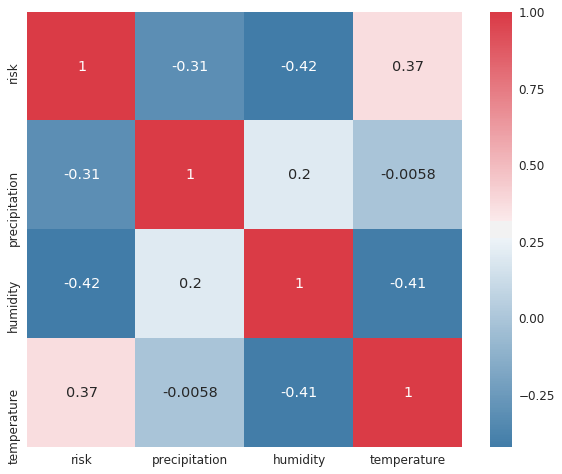

In [21]:
# Gerando matrix de correlação
sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(10, 8))
corr = dados.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
            square=True, ax=ax, annot=True) 

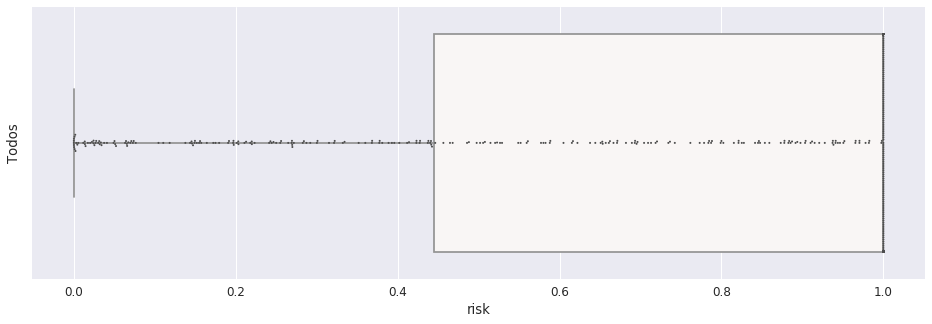

In [22]:
# Boxplot de todos os dados
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="risk", data=dados, palette="vlag" )
sns.swarmplot(x="risk", data=dados, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True) 
ax.set(ylabel="Todos")
sns.despine(trim=True, left=True)

In [ ]:
# Gerando scatterplot matrix
sns.pairplot(dados)

### Por região
<hr style="border:2px solid #0077b9;">
- N, NE, CO, SE e S

In [ ]:
# Gerando matrix de correlação para cada região

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in xrange(0, 5):
    corr = dados[dados['regiao'] == siglas[i]].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
                square=True, ax=ax[i], annot=True, vmin=-1, vmax=1)
    ax[i].set_title(regioes[i])

ax6.set_visible(False)
f.subplots_adjust(hspace=0.4, top=4, right=2.5)

In [ ]:
# Gerando scatterplot matrix por região
sns.set(font_scale=2)
color_regions = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
sns.pairplot(dados, hue="regiao", palette=sns.color_palette(color_regions), size=4)

In [ ]:
# Histogramas para cada região
from scipy import stats, integrate
sns.set(color_codes=True)

sns.set(font_scale=2)
sns.set_context("paper", rc={"font.size":28,"axes.titlesize":22,"axes.labelsize":22})   
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in xrange(0, 5):
    sns.distplot(dados[dados['regiao'] == siglas[i]]["risk"], ax=ax[i], kde=False, bins=np.arange(0.0, 1.1, 0.1), color=color_regions[i], hist_kws=dict(edgecolor="k", linewidth=2))
    ax[i].set_title(regioes[i])
    ax[i].tick_params(labelsize=22)
    plt.setp( ax[i].get_xticklabels(), visible=True)

ax[5].set_visible(False)
plt.subplots_adjust(hspace=0.4, top=3, right=1.9)

In [ ]:
# Gerando boxplot para (risco, temperatura, precipitação, umidade) por região

sns.set(font_scale=1.5)

for var in ("risk", "temperature", "precipitation", "humidity"):
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(ax=ax, x=var,  y="regiao", data=dados, palette=color_regions)
    sns.swarmplot(x=var, y="regiao", data=dados, size=2, color=".3", linewidth=0)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)

### Por estações
<hr style="border:2px solid #0077b9;">
- Primavera, Verão, Outono e Inverno

In [ ]:
# Separando dados por estação

# períodos das estacoes no hemisfério sul
primavera = (dados['timestamp'] > '2016-09-23') & (dados['timestamp'] <= '2016-12-21')
verao = (dados['timestamp'] > '2016-12-21') | ( (dados['timestamp'] >= '2016-01-01') & (dados['timestamp'] < '2016-03-21') )
outono = (dados['timestamp'] > '2016-03-21') & (dados['timestamp'] <= '2016-06-20')
inverno = (dados['timestamp'] > '2016-06-20') & (dados['timestamp'] <= '2016-09-23')

# Criando coluna estacao
dados['estacao']=''
dados.loc[primavera, 'estacao']="primavera"
dados.loc[verao, 'estacao']="verao"
dados.loc[outono,'estacao']="outono"
dados.loc[inverno, 'estacao']='inverno'

# Contado por grupo de risco e por estação
dados.filter(items=["risk", "estacao"])\
     .groupby(["estacao",pd.cut(dados["risk"], np.arange(0, 1+.25, .25))])\
     .count().rename(columns={'risk':'Total'})

In [ ]:
# Boxplot para Estação-Risco

colors = ["faded green", "windows blue", "amber", "greyish"]
colors_estacoes = sns.xkcd_palette(colors).as_hex()

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="risk", y="estacao", data=dados, palette=colors_estacoes)
sns.swarmplot(x="risk", y="estacao", data=dados, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [ ]:
# Ocorrências por Região-Estação

sns.set(font_scale=1.2)
estacao_regiao=pd.DataFrame(index=("N ", "NE", "CO", "SE", "S "))
for estacao in ("primavera", "verao", "outono", "inverno"): 
    for regiao in ("N ", "NE", "CO", "SE", "S "):
        estacao_regiao.set_value(regiao, estacao, len(dados.loc[ (dados['estacao']==estacao) & (dados['regiao']==regiao)]))

sns.heatmap(estacao_regiao, cmap=palette, annot=True,  fmt='g')

In [ ]:
# Boxplot Região-Estação

sns.set(font_scale=1.5)
for estacao,i in zip(("primavera", "verao", "outono", "inverno"), xrange(0,5)): 
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(x="risk", y="regiao", data=dados.loc[dados['estacao']==estacao] , palette=color_regions, ax=ax)
    sns.swarmplot(x="risk", y="regiao", data=dados.loc[dados['estacao']==estacao], size=2, color=".3", linewidth=0, ax=ax)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    ax.set_title(estacao)

## Links
<hr style="border:2px solid #0077b9;">


- **simple_geo.py**: [http://github.com/esensing/simple_geo.py/](http://github.com/esensing/simple_geo.py/)
- WTSS.py: [https://github.com/e-sensing/wtss.py](https://github.com/e-sensing/wtss.py)
- Seaborn: [https://seaborn.pydata.org/](https://seaborn.pydata.org/)